<a href="https://colab.research.google.com/github/abia200304/IIIT-Hyderabad-Research_works/blob/main/DBN_PEMS_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip -o /content/my_pems_data.zip

Archive:  /content/my_pems_data.zip
   creating: my_pems_data/
  inflating: my_pems_data/pems_station_500011021_flow_04-01-2024_0600_to_04-07-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-08-2024_0600_to_04-14-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-15-2024_0600_to_04-21-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-22-2024_0600_to_04-28-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-29-2024_0600_to_05-05-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-06-2024_0600_to_05-12-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-13-2024_0600_to_05-19-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-20-2024_0600_to_05-26-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-27-2024_0600_to_06-02-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_06-03-2024_0600_to_06-09-202

In [ ]:

# display(processed_df)
# print(processed_df.shape)

,total_flow,truck_flow,non_truck_flow,time_index
0,14.0,0.0,14.0,0
1,30.0,0.0,30.0,1
2,25.0,0.0,25.0,2
3,15.0,0.0,15.0,3
4,16.0,0.0,16.0,4
...,...,...,...,...
22819,38.0,0.0,38.0,22819
22820,40.0,0.0,40.0,22820
22821,41.0,0.0,41.0,22821
22822,30.0,0.0,30.0,22822


(22824, 4)


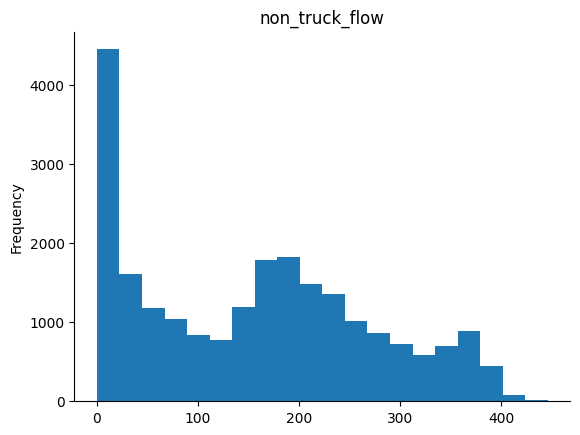

In [ ]:
# from matplotlib import pyplot as plt
# processed_df['non_truck_flow'].plot(kind='hist', bins=20, title='non_truck_flow')
# plt.gca().spines[['top', 'right',]].set_visible(False)

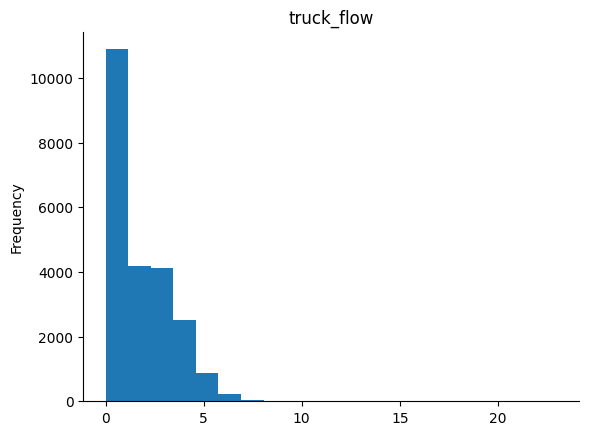

In [ ]:

# from matplotlib import pyplot as plt
# processed_df['truck_flow'].plot(kind='hist', bins=20, title='truck_flow')
# plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
from glob import glob
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# --- Data Loading and Initial Processing ---
file_paths = glob('/content/my_pems_data/*.csv')
all_data = []

for file in file_paths:
    try:
        df = pd.read_csv(file, delimiter='\t')
        df.columns = df.columns.str.strip()
        if 'Flow (Veh/5 Minutes)' in df.columns and 'Truck Flow (Veh/5 Minutes)' in df.columns:
            all_data.append(df[['Flow (Veh/5 Minutes)', 'Truck Flow (Veh/5 Minutes)']])
        else:
            print(f"Skipping {file}: Required columns not found")
    except Exception as e:
        print(f"Error reading {file}: {e}")

if all_data:
    combined_df = pd.concat(all_data, ignore_index=True)
    print(f"Combined DataFrame shape: {combined_df.shape}")
else:
    print("No data found or processed. Exiting.")
    exit() # Exit if no data to process

def process_traffic_data(df):
    processed_df = df.copy()

    processed_df = processed_df.rename(columns={
        'Flow (Veh/5 Minutes)': 'total_flow',
        'Truck Flow (Veh/5 Minutes)': 'truck_flow' #renaming
    })

    if 'total_flow' not in processed_df.columns or 'truck_flow' not in processed_df.columns:
        print("Error: Renaming of columns failed. Check original column names.")
        return None

    # Calculate Non-Truck Flow = Total Flow - Truck Flow
    processed_df['non_truck_flow'] = processed_df['total_flow'] - processed_df['truck_flow']

    # Handle any negative values
    negative_mask = processed_df['non_truck_flow'] < 0
    if negative_mask.sum() > 0:
        print(f"⚠️ Warning: {negative_mask.sum()} rows have negative non-truck flow values")
        processed_df.loc[negative_mask, 'non_truck_flow'] = 0

    # Add time-based features (though 'time_index' might not be used directly in DBN input)
    processed_df['time_index'] = range(len(processed_df))

    return processed_df

processed_df = process_traffic_data(combined_df)

if processed_df is None:
    print("Failed to process data. Exiting.")
    exit()

print("Processed DataFrame:")
# display(processed_df) # Uncomment if you are in an environment like Jupyter
print(f"Processed DataFrame shape: {processed_df.shape}")
print(f"Processed DataFrame columns: {processed_df.columns.tolist()}")

column_1_data = processed_df['truck_flow']
column_2_data = processed_df['non_truck_flow']

# Ensure these are numpy arrays
column_1_data = np.array(column_1_data)
column_2_data = np.array(column_2_data)

# Reshape to 2D arrays (number_of_samples, number_of_features)
column1_data = column_1_data.reshape(-1, 1)
column2_data = column_2_data.reshape(-1, 1)

# Concatenate for scaling
data = pd.concat([pd.DataFrame(column1_data), pd.DataFrame(column2_data)], axis=1)
print(f"Concatenated data shape before scaling: {data.shape}")

# Scale the data
scaler = MinMaxScaler((0, 1))
scaled_data = scaler.fit_transform(data)
print(f"Scaled data shape: {scaled_data.shape}")

# --- RBM Class ---
class RBM:
    """Restricted Boltzmann Machine for DBN"""
    def __init__(self, n_visible, n_hidden, learning_rate=0.01):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate

        # Initialize weights and biases
        self.W = np.random.normal(0, 0.01, (n_visible, n_hidden))
        self.b_visible = np.zeros(n_visible)
        self.b_hidden = np.zeros(n_hidden)

    def sigmoid(self, x):
        """Sigmoid activation function"""
        return 1 / (1 + np.exp(-np.clip(x, -250, 250)))

    def sample_hidden(self, visible):
        """Sample hidden units given visible units"""
        hidden_probs = self.sigmoid(np.dot(visible, self.W) + self.b_hidden)
        return hidden_probs, hidden_probs # Returning probabilities for DBN

    def sample_visible(self, hidden):
        """Sample visible units given hidden units"""
        visible_probs = self.sigmoid(np.dot(hidden, self.W.T) + self.b_visible)
        return visible_probs, visible_probs # Returning probabilities for reconstruction

    def contrastive_divergence(self, visible_data, k=1):
        """Contrastive Divergence learning"""
        # Positive phase,Calculates hidden unit probabilities based on the actual input
        pos_hidden_probs, pos_hidden_samples = self.sample_hidden(visible_data)

        # Negative phase - Initialize neg_hidden_samples before the loop
        neg_visible_probs = visible_data
        neg_hidden_probs, neg_hidden_samples = self.sample_hidden(neg_visible_probs) # Initialize

        for _ in range(k - 1): # Loop k-1 times since the first step is done
            neg_visible_probs, neg_visible_samples = self.sample_visible(neg_hidden_samples)
            neg_hidden_probs, neg_hidden_samples = self.sample_hidden(neg_visible_probs)

        # Update weights and biases
        self.W += self.learning_rate * (np.dot(visible_data.T, pos_hidden_probs) -
                                       np.dot(neg_visible_probs.T, neg_hidden_probs))
        self.b_visible += self.learning_rate * np.mean(visible_data - neg_visible_probs, axis=0)
        self.b_hidden += self.learning_rate * np.mean(pos_hidden_probs - neg_hidden_probs, axis=0)

        # Calculate reconstruction error
        error = np.mean(np.sum((visible_data - neg_visible_probs) ** 2, axis=1))
        return error

    def train(self, data, epochs=100, batch_size=32):
        """Train the RBM"""
        errors = []
        n_batches = len(data) // batch_size

        # Flatten the input data for RBM training if it's not already 2D
        if data.ndim > 2:
            flattened_data = data.reshape(data.shape[0], -1)
        else:
            flattened_data = data

        for epoch in range(epochs):
            epoch_errors = []
            np.random.shuffle(flattened_data)

            for i in range(n_batches):
                batch = flattened_data[i*batch_size:(i+1)*batch_size]
                error = self.contrastive_divergence(batch)
                epoch_errors.append(error)

            errors.append(np.mean(epoch_errors))
            if epoch % 20 == 0:
                print(f"RBM Epoch {epoch}, Error: {errors[-1]:.4f}")

        return errors

    def transform(self, data):
        """Transform data to hidden representation"""
        # Flatten the input data for transformation if it's not already 2D
        if data.ndim > 2:
            flattened_data = data.reshape(data.shape[0], -1)
        else:
            flattened_data = data
        hidden_probs, _ = self.sample_hidden(flattened_data)
        return hidden_probs

# --- DBN Class ---
class DBN:
    """Deep Belief Network for Traffic Flow Prediction"""
    def __init__(self, layer_sizes, learning_rate=0.01):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.rbms = []

        # Create RBMs for each layer
        for i in range(len(layer_sizes) - 1):
            rbm = RBM(layer_sizes[i], layer_sizes[i+1], learning_rate)
            self.rbms.append(rbm)

    def pretrain(self, data, epochs=100, batch_size=32):
        """Pre-train the DBN layer by layer"""
        print("Starting DBN pre-training...")
        current_data = data.copy()

        for i, rbm in enumerate(self.rbms):
            print(f"\nPre-training layer {i+1}")
            # Ensure data is flattened correctly for the RBM input
            if current_data.ndim > 2:
                current_data_for_rbm = current_data.reshape(current_data.shape[0], -1)
            else:
                current_data_for_rbm = current_data

            rbm.train(current_data_for_rbm, epochs, batch_size)
            current_data = rbm.transform(current_data_for_rbm) # Get hidden representation for the next layer

        print("Pre-training completed!")

    def build_fine_tuning_model(self, input_shape, output_shape):
        """Build the fine-tuning neural network"""
        model = Sequential()

        # Add layers based on DBN structure
        model.add(Dense(self.layer_sizes[1], activation='sigmoid', input_shape=(input_shape,)))

        for i in range(2, len(self.layer_sizes)):
            model.add(Dense(self.layer_sizes[i], activation='sigmoid'))

        # Output layer for regression
        model.add(Dense(output_shape, activation='linear'))

        # Initialize weights from pre-trained RBMs
        for i, rbm in enumerate(self.rbms):

            model.layers[i].set_weights([rbm.W, rbm.b_hidden])

        return model

# --- TrafficFlowPredictor Class ---
class TrafficFlowPredictor:
    """Main class for traffic flow prediction using DBN"""
    def __init__(self, timestep=15):
        self.timestep = timestep

        self.dbn = None
        self.model = None

    def create_sequences(self, dataset):
        """Create sequences for time series prediction"""
        X, Y = [], []
        for i in range(len(dataset)-self.timestep): # Use self.timestep
            a = dataset[i:(i+self.timestep), :]
            X.append(a)
            Y.append(dataset[i + self.timestep, :])
        return np.array(X), np.array(Y)

    def train_with_scaled_data(self, original_data, scaled_data, pretrain_epochs=50, finetune_epochs=100, batch_size=32):
        """Train the DBN model with pre-scaled data"""
        print("Training with pre-scaled data...")

        # Create sequences directly from scaled data
        global X, Y # Declare X and Y as global
        X, Y = self.create_sequences(scaled_data)

        print(f"Training data shape: X={X.shape}, Y={Y.shape}")

        # Split data
        X_train=X[:int(0.8*len(X))]
        y_train = Y[:int(0.8*len(Y))].reshape(-1,2)
        X_test = X[int(0.8*len(X)):]
        y_test = Y[int(0.8*len(Y)):].reshape(-1,2)

        # Initialize DBN
        input_size = self.timestep * scaled_data.shape[1] # Use scaled_data.shape[1] for number of features
        layer_sizes = [input_size, 64, 32]   # Architecture
        self.dbn = DBN(layer_sizes)

        # Pre-train DBN
        self.dbn.pretrain(X_train, epochs=pretrain_epochs, batch_size=batch_size)

        # Build fine-tuning model
        self.model = self.dbn.build_fine_tuning_model(input_size, scaled_data.shape[1]) # Output shape should match features
        self.model.compile(optimizer=Adam(learning_rate=0.001),
                           loss='mse',
                           metrics=['mae'])

        # Fine-tune the model
        print("\nStarting fine-tuning...")
        # Flatten X_train and X_test for the fine-tuning model
        history = self.model.fit(X_train.reshape(X_train.shape[0], -1), y_train,
                                 epochs=finetune_epochs,
                                 batch_size=batch_size,
                                 validation_data=(X_test.reshape(X_test.shape[0], -1), y_test),
                                 verbose=1)

        # Evaluate model
        train_loss = self.model.evaluate(X_train.reshape(X_train.shape[0], -1), y_train, verbose=0)
        test_loss = self.model.evaluate(X_test.reshape(X_test.shape[0], -1), y_test, verbose=0)

        return history, X_test, y_test

    def predict(self, data):
        """Make predictions using the trained model."""
        # Flatten the input data for prediction
        flattened_data = data.reshape(data.shape[0], -1)
        # Predict using the Keras model
        predictions = self.model.predict(flattened_data, verbose=0)
        return predictions

# --- Example usage with pre-scaled data ---
if __name__ == "__main__":
    # Access the scaled_data variable from the global scope
    global scaled_data
    global data
    global X, Y
    global predictor # Declare predictor as global

    # Use your existing scaled_data
    scaled_data_for_training = scaled_data

    # Create predictor
    predictor = TrafficFlowPredictor(timestep=15)

    # Train with pre-scaled data
    history, X_test, y_test = predictor.train_with_scaled_data(data, scaled_data_for_training,
                                                               pretrain_epochs=30,
                                                               finetune_epochs=50)

Combined DataFrame shape: (22824, 2)
Processed DataFrame:
Processed DataFrame shape: (22824, 4)
Processed DataFrame columns: ['total_flow', 'truck_flow', 'non_truck_flow', 'time_index']
Concatenated data shape before scaling: (22824, 2)
Scaled data shape: (22824, 2)
Training with pre-scaled data...
Training data shape: X=(22809, 15, 2), Y=(22809, 2)
Starting DBN pre-training...

Pre-training layer 1
RBM Epoch 0, Error: 0.0000
RBM Epoch 20, Error: 0.0000

Pre-training layer 2
RBM Epoch 0, Error: 0.0000
RBM Epoch 20, Error: 0.0000
Pre-training completed!

Starting fine-tuning...
Epoch 1/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1285 - mae: 0.2052 - val_loss: 0.0035 - val_mae: 0.0439
Epoch 2/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0034 - mae: 0.0424 - val_loss: 0.0022 - val_mae: 0.0346
Epoch 3/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0023 - mae: 0.0344 - val_loss: 0.0019 - val_mae: 0.0316
Epoch 4/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

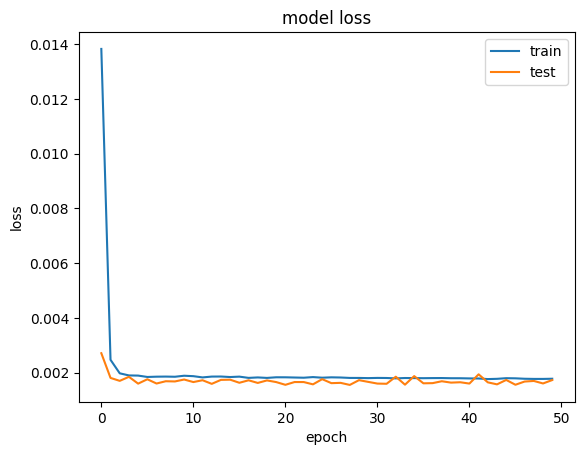

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
y_pred=predictor.predict(X_test)
test_predict=predictor.predict(X_test)
print(test_predict.shape)
predictions_original_scale = scalar.inverse_transform(test_predict)
y_test_original_scale = scalar.inverse_transform(y_test)
mae=mean_absolute_error(predictions_original_scale,y_test_original_scale,)
mse=mean_squared_error(predictions_original_scale,y_test_original_scale,)
rmse=np.sqrt(mse)
mape=mean_absolute_percentage_error(predictions_original_scale,y_test_original_scale,)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}")

(4562, 2)
RMSE: 13.2584
MSE: 175.7851
MAE: 7.1640
MAPE: 0.3445
